# Understanding the Bias-Variance Tradeoff

**Objective:** This notebook provides an interactive, hands-on demonstration of the bias-variance tradeoff, a fundamental concept in machine learning. You will explore how model complexity affects model error and how techniques like ensembling can change the balance between bias and variance.

**Prerequisites:** You should be comfortable with basic machine learning concepts and have some familiarity with the scikit-learn library.

*Inspired from https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html*

## Part 1: The Theory

In supervised learning, our goal is to build a model that learns a function `f(x)` from training data `(X, y)`. The model's prediction is denoted by `ŷ(x)`. The expected error of our model at a point `x` can be decomposed into three components:

$$ \text{Expected Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error (Noise)}^2 $$

*(for a formal derivation of this, check out https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation)*

Let's break these down:

*   **Bias:** This is the error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting). In simple terms, bias measures how far off the *average* prediction of our model is from the true value we are trying to predict.
    *   *A **high-bias** model is too simple and makes strong assumptions about the data.*

*   **Variance:** This is the error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting). In simple terms, variance measures how much the prediction for a given point `x` varies if we were to retrain the model on different random subsets of our data.
    *   *A **high-variance** model is too complex and adapts too much to the training data.*

*   **Irreducible Error (Noise):** This error is inherent to the data itself, as in most cases the generative process is actually of the form f(x) + $\epsilon$. It's the noise term that we can't fundamentally predict, no matter how good our model is.

In [2]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn for modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

# PyTorch for the Neural Network part
import torch
import torch.nn as nn

# Settings for the experiment
n_repeat = 50  # Number of different random datasets to generate
n_train = 50   # Size of each training set
n_test = 1000  # Size of the test set
noise = 0.1    # Standard deviation of the noise
np.random.seed(42) # for reproducibility
torch.manual_seed(42)

## Part 2: The Experimental Setup

To measure bias and variance, we need a controlled environment. We will:
1.  Define a "ground truth" function, `f(x)`, which our models will try to learn.
2.  Generate multiple noisy training sets from this function. This simulates the real-world scenario where we only have a random sample of data.
3.  Create a single, large, noise-free test set to consistently evaluate the models.

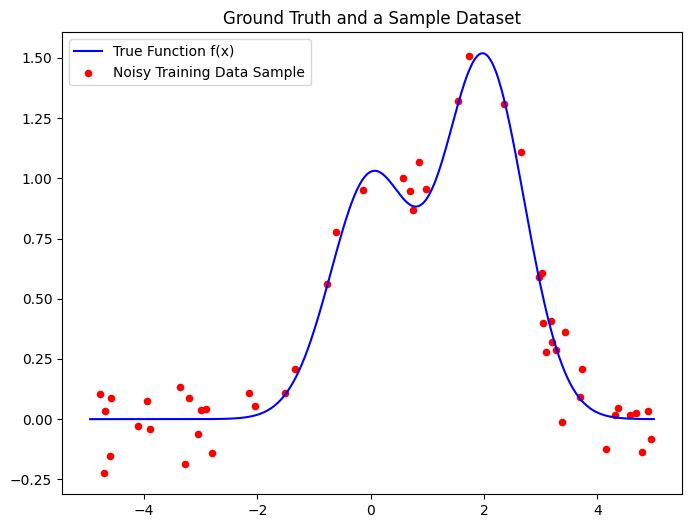

In [3]:
# This is our "ground truth" function. It's non-linear and has some complexity.
def f(x):
    x = x.ravel()
    return np.exp(-(x**2)) + 1.5 * np.exp(-((x - 2) ** 2))

# This function generates many different datasets based on the ground truth function f.
def generate_data(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

 # Generate the test sets, same X for all repeats, but different y
X_test, y_test_sets = generate_data(n_test, noise, n_repeat)
# the true function values for the test set
y_test_true = f(X_test)

# Let's visualize the true function and one random training set
X_train_sample, y_train_sample = generate_data(n_train, noise)

plt.figure(figsize=(8, 6))
plt.plot(X_test, y_test_true, 'b-', label="True Function f(x)")
plt.scatter(X_train_sample, y_train_sample, c='r', s=20, marker='o', label="Noisy Training Data Sample")
plt.title("Ground Truth and a Sample Dataset")
plt.legend()
plt.show()

## The Simulation Framework

The code cell below contains a function, `run_bias_variance_analysis`, that performs the entire experiment. You don't need to modify this code.

**What it does:**
1.  Takes a list of scikit-learn estimator models that you will define.
2.  For each estimator:
    - It loops `n_repeat` times. In each loop, it generates a new noisy training set and fits the estimator to it.
    - It stores the predictions of each fitted estimator on the `X_test` set.
3.  It then uses all the stored predictions to calculate the `bias²`, `variance`, and `total error`.
4.  Finally, it generates the two key plots for you to analyze.

In [ ]:
def run_bias_variance_analysis(estimators, X_test, y_test_true, y_test_sets):
    """
    Performs the bias-variance decomposition experiment for a list of estimators.
    """
    n_estimators = len(estimators)
    plt.figure(figsize=(6 * n_estimators, 10))

    # Generate the different training sets: different X and y for each repeat
    X_train_sets, y_train_sets = [], []
    for i in range(n_repeat):
        X, y = generate_data(n_train, noise)
        X_train_sets.append(X)
        y_train_sets.append(y)
        

    # Loop over estimators to compare
    for n, (name, estimator) in enumerate(estimators):
        # Array to store predictions from each model trained on a different dataset
        y_predict = np.zeros((n_test, n_repeat))

        # Train n_repeat models and store their predictions
        for i in range(n_repeat):
            estimator.fit(X_train_sets[i], y_train_sets[i])
            y_predict[:, i] = estimator.predict(X_test)

        # calculate the error
        error = np.zeros(n_test)
        # we average the error over all datasets and all predictions
        for i in range(n_repeat):
            for j in range(n_repeat):
                error += (y_test_sets[:, j] - y_predict[:, i]) ** 2

        error /= n_repeat * n_repeat

        # --- Bias-Variance Calculation ---
        # Bias^2 = (Average Prediction of y for each x value - True Value [we use f(X) to have the true response without noise])^2
        y_predict_mean = np.mean(y_predict, axis=1)
        bias_sq = (y_predict_mean - f(X_test)) ** 2
        # Variance = Average of (Prediction - Average Prediction)^2
        variance = np.var(y_predict, axis=1)
        # here we are getting the variance of the test sets, which is the noise variable defined above squared
        noise_sq = np.var(y_test_sets, axis=1).mean() 

        print(f"--- {name} ---")
        print(f"Average Error: {np.mean(error):.4f}")
        print(f"  Bias^2:      {np.mean(bias_sq):.4f}")
        print(f"  Variance:    {np.mean(variance):.4f}")
        print(f"  Noise^2:       {noise_sq:.4f}\n")

        # --- Plotting ---
        # Plot 1: Prediction "Beam"
        ax1 = plt.subplot(2, n_estimators, n + 1)
        ax1.plot(X_test, y_test_true, "b", label="$f(x)$ (True Function)")
        ax1.scatter(X_train_sets[0], y_train_sets[0], c='r', s=15, marker='.', label="Training Sample")
        # Plot the "beam" of all predictions
        for i in range(n_repeat):
            ax1.plot(X_test, y_predict[:, i], "g", alpha=0.1)
        ax1.plot(X_test, y_predict_mean, "c", lw=3, label=r"$\mathbb{E}[\^y(x)]$ (Avg. Prediction)")
        ax1.set_title(name)
        ax1.legend()

        # Plot 2: Error Decomposition
        ax2 = plt.subplot(2, n_estimators, n_estimators + n + 1)
        ax2.plot(X_test, error, "r", label="$Total Error(x)$")
        ax2.plot(X_test, bias_sq, "b", label="$bias^2(x)$")
        ax2.plot(X_test, variance, "g", label="$variance(x)$")
        ax2.plot(X_test, np.full(X_test.shape, noise_sq), "c", label="$noise^2$")
        ax2.set_title("Error Decomposition")
        ax2.legend()
        
    plt.tight_layout()
    plt.show()

## Part 3: Core Demonstration with Decision Trees

Now it's your turn. Your task is to define three different simple models (for example using `DecisionTreeRegressor` and `BaggingRegressor` from scikit-learn). The goal is to create models that exhibit:
1.  High Bias
2.  High Variance
3.  Low Variance (through ensembling, i.e. Bagging)

In [ ]:
### EXERCISE 2: Define your models ###

# Your task is to define a list of tuples, where each tuple is (name, model).
# Follow the hints to create the three required models.

# A very simple tree with a small max_depth will be rigid and have high bias.
high_bias_model = # YOUR CODE HERE

# A very complex tree with no depth limit will fit the noise and have high variance.
high_variance_model =  # YOUR CODE HERE

# Bagging (Bootstrap Aggregating) averages many high-variance models to reduce variance.
# We will use the high-variance tree as the base estimator.
low_variance_model = # YOUR CODE HERE

# This list will be passed to our analysis function.
# The `None` values are placeholders for you to fill.
estimators = [
    ("High Bias (Shallow Tree)", high_bias_model),
    ("High Variance (Deep Tree)", high_variance_model),
    ("Low Variance (Bagged Trees)", low_variance_model),
]

--- High Bias (Shallow Tree) ---
Average Error: 0.1636
  Bias^2:      0.1395
  Variance:    0.0140
  Noise^2:       0.0098

--- High Variance (Deep Tree) ---
Average Error: 0.0241
  Bias^2:      0.0003
  Variance:    0.0138
  Noise^2:       0.0098

--- Low Variance (Bagged Trees) ---
Average Error: 0.0188
  Bias^2:      0.0004
  Variance:    0.0084
  Noise^2:       0.0098



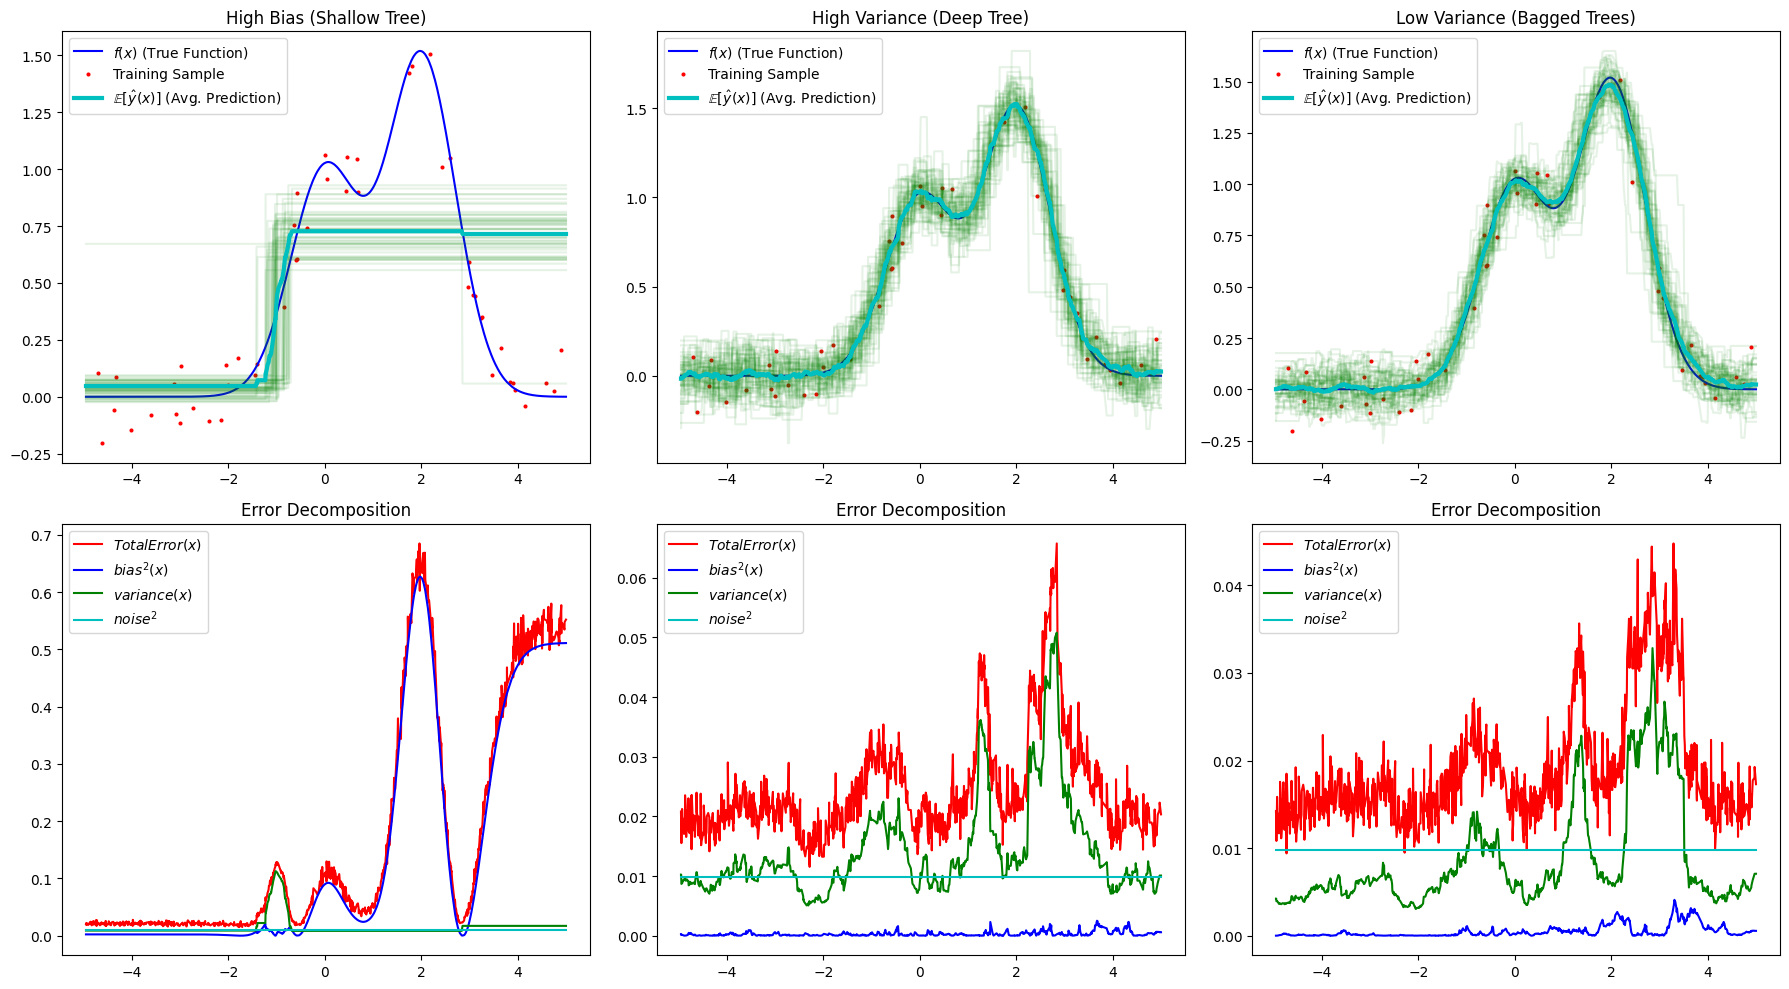

In [11]:
# This cell runs the full analysis with the models you defined above.
# You do not need to change this cell. Just run it after completing Exercise 2.
run_bias_variance_analysis(estimators, X_test, y_test_true.ravel(), y_test_sets)

### Exercise 3: Interpretation

*Double-click this cell and answer the following questions based on the plots and numbers from the cell above.*

**1. Compare the `Bias²` and `Variance` for your "High Bias" and "High Variance" models. Did the results match what you expected? Explain why, referring to the `max_depth` parameter.**
   > [Your Answer Here]

**2. Look at the "prediction beam" (the light green lines) for the "High Variance" model versus the "Bagged" model. Describe the difference you see.**
   > [Your Answer Here]

**3. What was the effect of Bagging on the Bias? What was its effect on the Variance? What does this tell you about the primary strength of Bagging?**
   > [Your Answer Here]

## Part 4: Connection to Neural Networks

The principles of bias and variance apply to *all* machine learning models, including neural networks.

-   **High Bias in NNs:** Often caused by a network that is too simple (e.g., too few layers, too few neurons) or is under-trained (not enough epochs). It doesn't have the **capacity** to learn the true function.
-   **High Variance in NNs:** Often caused by a network that is too complex (e.g., too many layers/neurons) or is over-trained. It has so much capacity that it starts to memorize the noise in the training data.

Let's do a simpler, qualitative experiment. We will train two NNs on a single training set (for the sake of time) and observe their behavior. We won't be able to decompose the error as before but we can still gauge their performance against the true function f(X).

In [ ]:
# Helper function to train and plot a PyTorch NN model
def train_and_plot_nn(model, name):
    """Trains a PyTorch model and plots its predictions."""
    # Convert data to torch tensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    X_train_torch = torch.from_numpy(X_train_sample).float().to(device)
    y_train_torch = torch.from_numpy(y_train_sample).float().reshape(-1, 1).to(device)
    X_test_torch = torch.from_numpy(X_test).float().to(device)
    
    # Simple training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    for epoch in range(2000):
        y_pred = model(X_train_torch)
        loss = loss_fn(y_pred, y_train_torch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Plotting
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_torch).cpu().numpy()
    
    plt.plot(X_test, y_test_true, 'b-', label="True Function f(x)")
    plt.scatter(X_train_sample, y_train_sample, c='r', s=20, marker='.', label="Noisy Training Data")
    plt.plot(X_test, y_pred_test, 'g-', lw=2, label="NN Prediction")
    plt.title(f"NN Model: {name}")
    plt.legend()
    plt.show()

In [ ]:
### EXERCISE 4: Define your NN models ###

# Your task is to define two simple neural networks using torch.nn.Sequential.
# One should be low-complexity (high bias) and the other high-complexity (high variance).

input_dim = 1
output_dim = 1

# A model with few neurons and layers lacks capacity.
low_complexity_nn = # YOUR CODE HERE: A simple architecture

# A model with many neurons and layers has high capacity to memorize noise.
high_complexity_nn = # YOUR CODE HERE: A more complex architecture

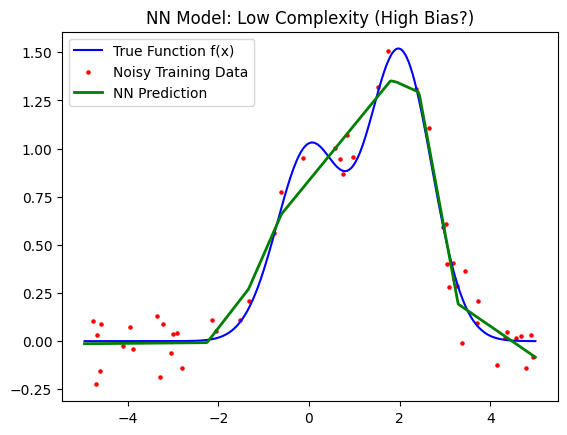

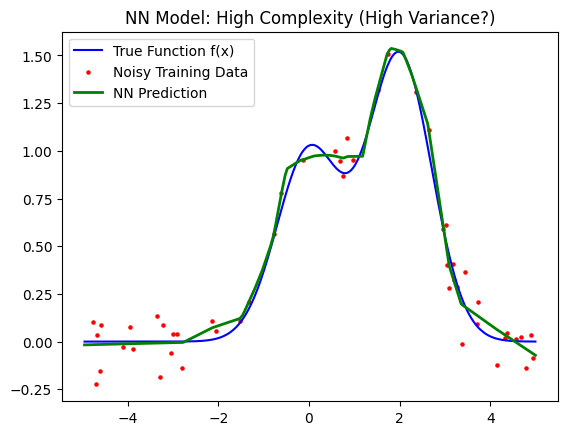

In [14]:
# Run the training and plotting for the low-complexity model
train_and_plot_nn(low_complexity_nn, "Low Complexity (High Bias?)")

# Run the training and plotting for the high-complexity model
train_and_plot_nn(high_complexity_nn, "High Complexity (High Variance?)")

### Exercise 5: Final Interpretation

*Double-click this cell and answer the following questions based on the two NN plots above.*

**1. Which of your two neural networks fits the noisy red training data points more closely? What does this suggest about its variance?**
   > [Your Answer Here]

**2. Which network provides a smoother, more generalized fit? What does this suggest about its bias?**
   > [Your Answer Here]

**3. The high-complexity network shows "wiggles" in areas where there is no data. What real-world problem does this behavior represent, and why is it dangerous for a machine learning model?**
   > [Your Answer Here]

## Conclusion

In this notebook, you have empirically verified the bias-variance tradeoff.

**Key Takeaways:**
*   **Simple models (like shallow trees or small NNs) are often high-bias and low-variance.** They are stable but may not be accurate because they can't capture the underlying complexity of the data.
*   **Complex models (like deep trees or large NNs) are often low-bias and high-variance.** They are flexible enough to capture the true function but are also sensitive to noise, making them prone to overfitting.
*   **Techniques like Bagging are powerful because they primarily reduce variance.** By averaging many different overfitted models, we can get a combined model that is both accurate and robust. This is a core idea behind modern ensemble methods like Random Forests.

Finding the right model is always about finding the sweet spot in this tradeoff for your specific problem.